## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Import Dependencies

In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt

from ipywidgets import interact
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# %matplotlib qt
%matplotlib inline

### 1. Camera Calibration

#### 1.1 Load all chess board images

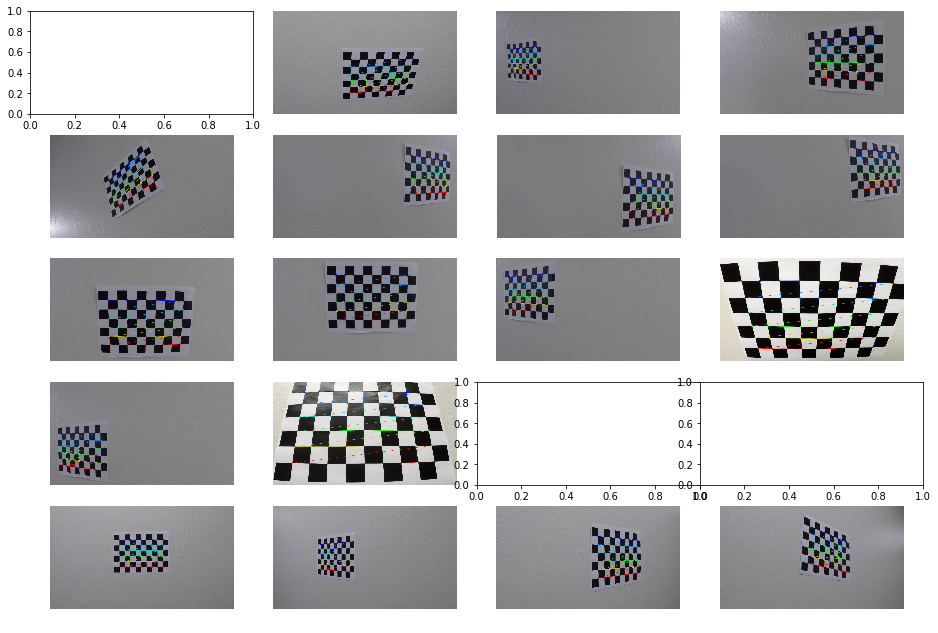

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

nx = 9
ny = 6

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
chessboard_images = glob.glob('./camera_cal/calibration*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i, img in enumerate(chessboard_images):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(image, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(image)
plt.show()

<span style="color:darkcyan">For image entries that did not show, it means the function did not find valid corners for the given images</span>.

#### 1.2. Define functions for image undistortion pipeline:

In [3]:
def perspective_transform(undisted_img, src, dst):
    img_size = (undisted_img.shape[1], undisted_img.shape[0]) 
    # Convert to grayscale
    gray = cv2.cvtColor(undisted_img, cv2.COLOR_BGR2GRAY)
    # Get the transformation matrix from given (src, dst) input
    transform_matrix = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Use cv2.warpPerspective() to warp your image desired view
    warped = cv2.warpPerspective(undisted_img, transform_matrix, img_size, flags=cv2.INTER_LINEAR)

    return warped, transform_matrix, Minv

def image_comparison_plot(imgBefore, sTitleBefore, imgAfter, sTitleAfter, oScopeSetting = None, bGrayscale = False):
    h, w = imgBefore.shape[0:2]
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    
    ax1.imshow(imgBefore)
    if oScopeSetting is not None:
        src = oScopeSetting["src"]
        src_x = [ src[0][0], src[1][0], src[2][0], src[3][0], src[0][0] ]
        src_y = [ src[0][1], src[1][1], src[2][1], src[3][1], src[0][1] ]
        ax1.plot(src_x, src_y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.set_title(sTitleBefore, fontsize=30)
    if bGrayscale:
        ax2.imshow(imgAfter, cmap='gray')
    else:
        ax2.imshow(imgAfter)
    if oScopeSetting is not None:
        dst = oScopeSetting["dst"]
        dst_x = [ dst[0][0], dst[1][0], dst[2][0], dst[3][0], dst[0][0] ]
        dst_y = [ dst[0][1], dst[1][1], dst[2][1], dst[3][1], dst[0][1] ]
        ax2.plot(dst_x, dst_y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax2.set_title(sTitleAfter, fontsize=30)
    ax2.set_ylim([h, 0])
    
    plt.show()
    
def get_undistorted_image(image, objpoints, imgpoints, bDrawCorners = False):
    img_size = (image.shape[1], image.shape[0])

    undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Find the chessboard corners
    if bDrawCorners == True:
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        gray_undist = cv2.cvtColor(undistorted_img, cv2.COLOR_BGR2GRAY)
        ret1, corners1 = cv2.findChessboardCorners(gray_img, (nx, ny), None)
        ret2, corners2 = cv2.findChessboardCorners(gray_undist, (nx, ny), None)
        # If found, draw corners
        if ret1 == True:
            # Draw and display the corners
            cv2.drawChessboardCorners(image, (nx, ny), corners1, ret1)
        if ret2 == True:
            # Draw and display the corners
            cv2.drawChessboardCorners(undistorted_img, (nx, ny), corners2, ret2)
            return undistorted_img, corners2, ret2
    
    return undistorted_img

def getImg(path):
    road_img = cv2.imread(path)
    return cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)
    
def img_perspective_transform(img, src, dst):
    # Get the undistorted image
    undistorted_img = get_undistorted_image(img, objpoints, imgpoints)

    # Perform the perspective transformation for road image
    unwarped_img, tranform_mat, Minv = perspective_transform(undistorted_img, src, dst)

    return unwarped_img, tranform_mat, Minv

In [4]:
def undistort_img(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def unwarp_img(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def get_l_thresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def get_blueYellowThresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def color_pipeline(img):
    img_undistort = undistort_img(img)
    img_unwarp, M, Minv = unwarp_img(img_undistort, src, dst)
    img_LThresh = get_l_thresh(img_unwarp)
    img_BThresh = get_blueYellowThresh(img_unwarp)
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv

#### 1.3. Test on image undistortion for chessboard image

In [5]:
# Get the test image
chessboard_img = cv2.imread(chessboard_images[13])
image_size = (chessboard_img.shape[1], chessboard_img.shape[0])

In [6]:
# Define the camera and distortion matrix for later use
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)

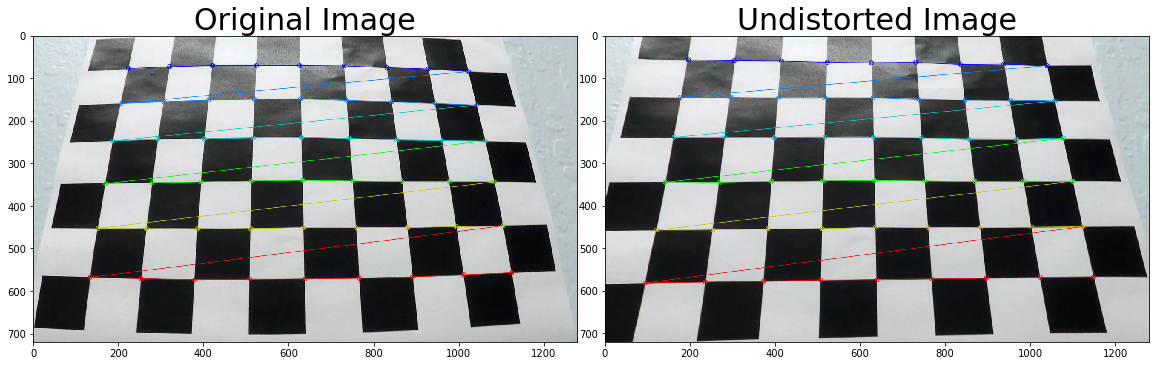

In [7]:
# Get the undistorted image
undistorted_img, corners, cornerFlag = get_undistorted_image(chessboard_img, 
                                                             objpoints, imgpoints, 
                                                             bDrawCorners = True)

# Make a comparison plot
image_comparison_plot(chessboard_img, 'Original Image', undistorted_img, 'Undistorted Image')

#### 1.4. Test on image perspective transformation for chessboard image

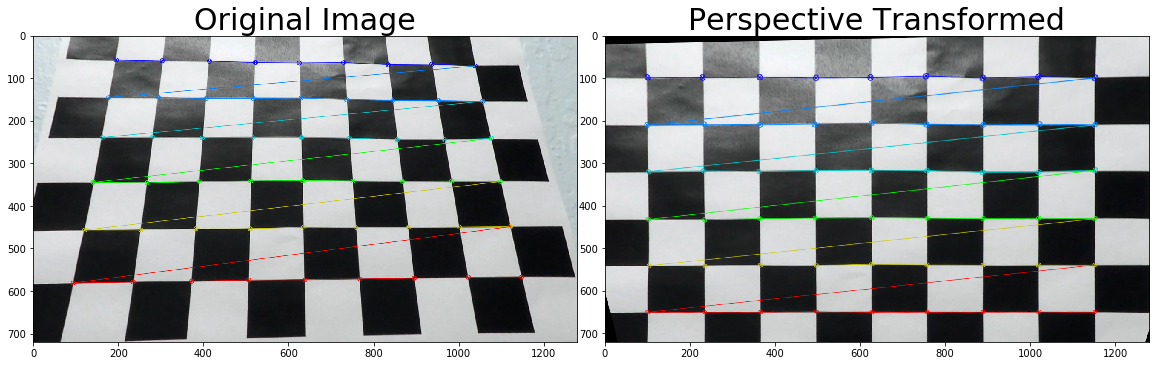

In [8]:
# Define the perspective transformation parameters
if cornerFlag == False:
    print("no corners found, skipping the corner drawing")
src = np.float32([corners[0][0], 
              corners[8][0], 
              corners[53][0], 
              corners[45][0]])
dst = np.float32([[100,100],
                  [1150, 100],
                  [1150, 650],
                  [100, 650]])
perspective_corrected, _, _ = perspective_transform(undistorted_img, src, dst)
image_comparison_plot(undistorted_img, 'Original Image', 
                      perspective_corrected, 'Perspective Transformed')

#### 1.5. Test on real image

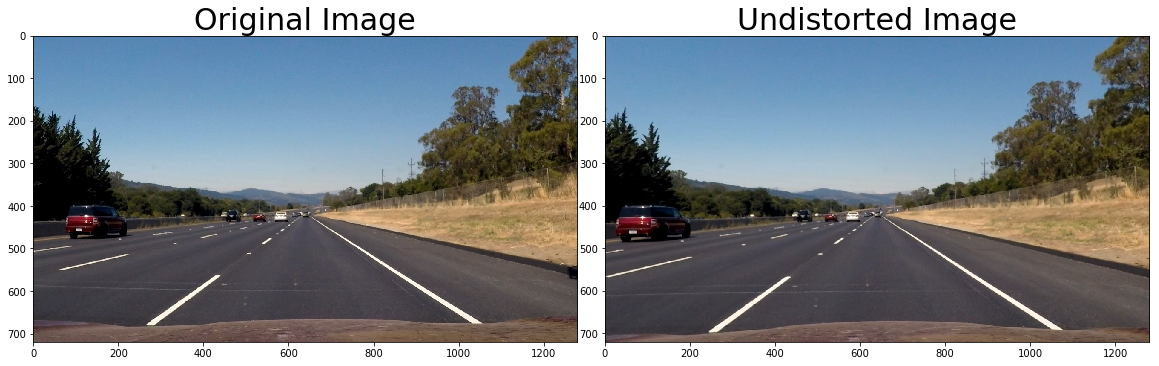

In [9]:
# get the road image
# road_img = cv2.imread('./test_images/test3.jpg')
road_img = cv2.imread('./test_images/straight_lines2.jpg')
road_img = cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB)

# Get the undistorted image
undistorted_roadImg = get_undistorted_image(road_img, objpoints, imgpoints)

image_comparison_plot(road_img, 'Original Image', undistorted_roadImg, 'Undistorted Image')


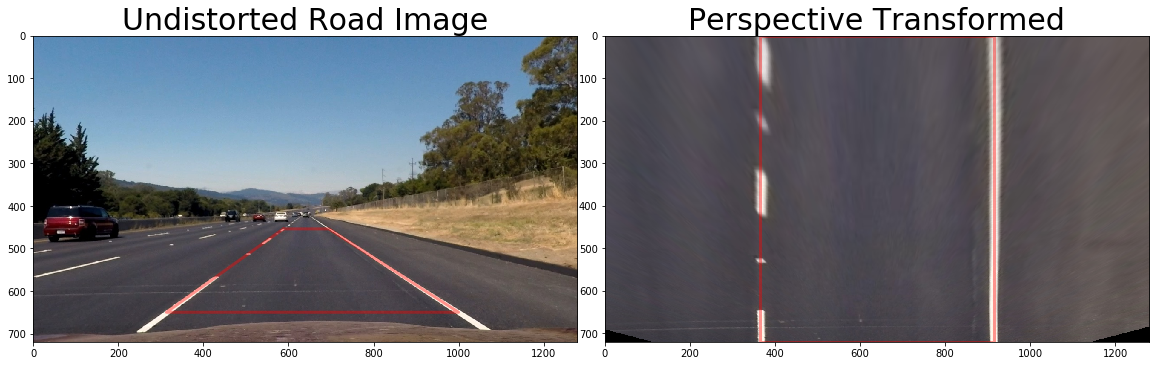

In [10]:
# Define the transformation matrix parameters
rows, cols = undistorted_roadImg.shape[:2]

left_ref_x = (cols * 2)//7
right_ref_x = (cols * 5)//7

src = np.float32([(588, 454),
                  (695, 454), 
                  (1000, 650), 
                  (313, 650)])

dst = np.float32([(left_ref_x,0),
                  (right_ref_x, 0),
                  (right_ref_x, rows),
                  (left_ref_x, rows)])

# Perform the perspective transformation for road image
unwarped_roadImage, _, _ = perspective_transform(undistorted_roadImg, src, dst)

# Plot comparison
image_comparison_plot(undistorted_roadImg, 'Undistorted Road Image', 
                      unwarped_roadImage, 'Perspective Transformed', 
                      oScopeSetting = {'src': src, 'dst': dst})

#### <span style="color:darkcyan">End of Camera Calibration Section</span>

### 2. Processing Pipeline for Stilled Image

#### 2.1. Define all thresholding functions for gradient

In [11]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your grad_binary image
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255), bSingleChannel = False):
    # Convert to grayscale
    if bSingleChannel == False:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    dir_binary =  np.zeros_like(grad_dir)
    dir_binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

    # Return the binary image
    return dir_binary

#### 2.2a Test sobel absolute threshold

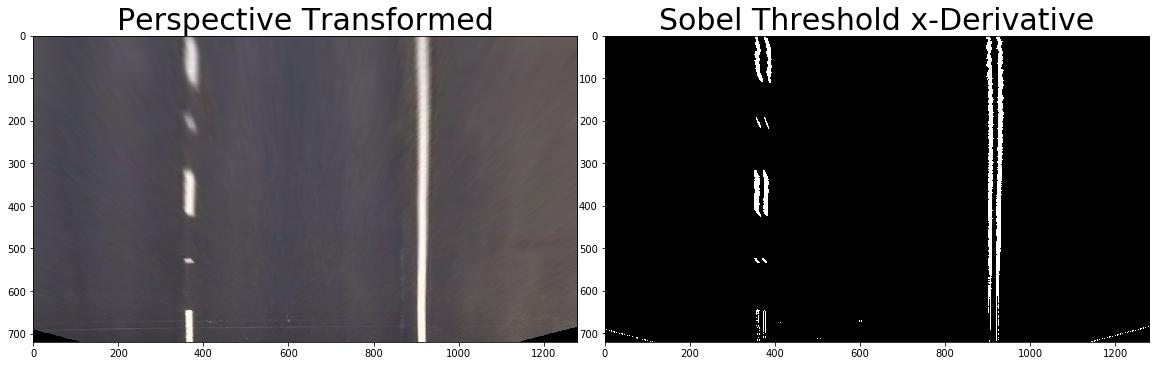

In [12]:
x_grad_binary = abs_sobel_thresh(unwarped_roadImage, 'x', 30, 140)
image_comparison_plot(unwarped_roadImage, 'Perspective Transformed', 
                      x_grad_binary, 'Sobel Threshold x-Derivative',
                      bGrayscale = True)

#### 2.2b Test sobel absolute threshold

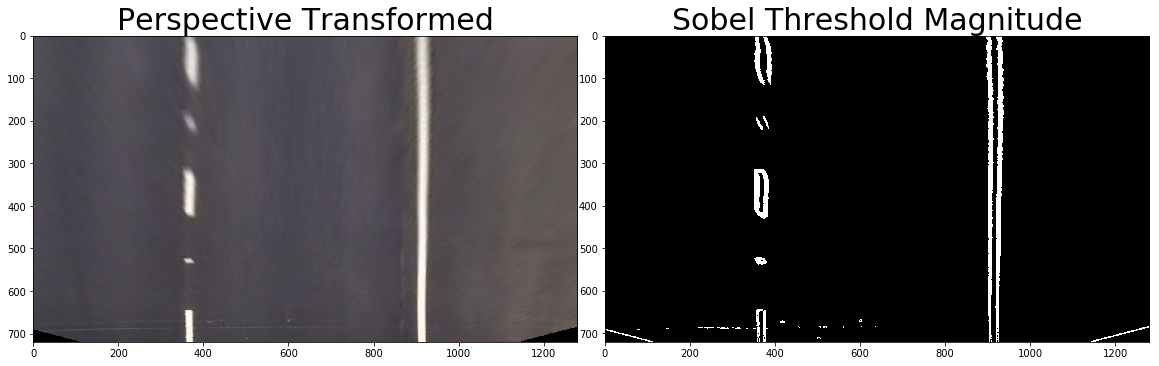

In [13]:
mag_binary = mag_thresh(unwarped_roadImage, 5,(30, 200))
image_comparison_plot(unwarped_roadImage, 'Perspective Transformed', 
                      mag_binary, 'Sobel Threshold Magnitude',
                      bGrayscale = True)

#### 2.2c Test sobel absolute threshold

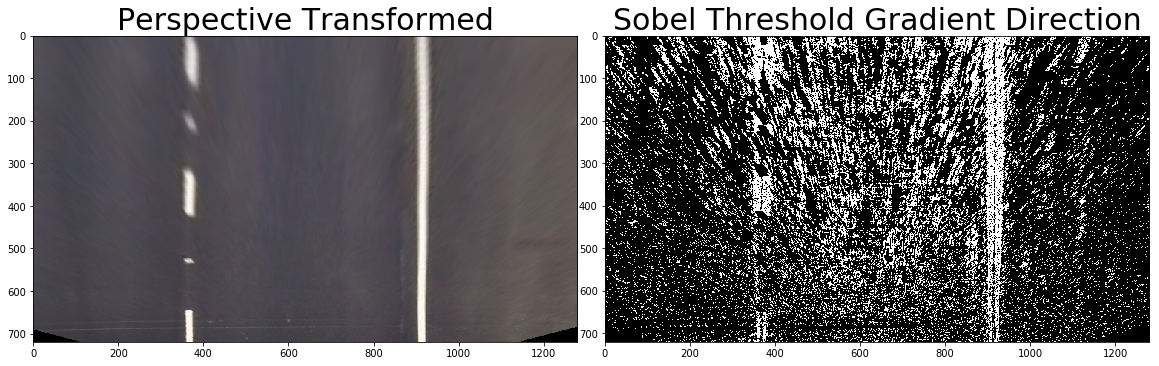

In [14]:
dir_binary = dir_thresh(unwarped_roadImage, 5, (0.02, 0.39))
image_comparison_plot(unwarped_roadImage, 'Perspective Transformed', 
                      dir_binary, 'Sobel Threshold Gradient Direction',
                      bGrayscale = True)

#### 2.2d Combine all three sobel thresholding binary images

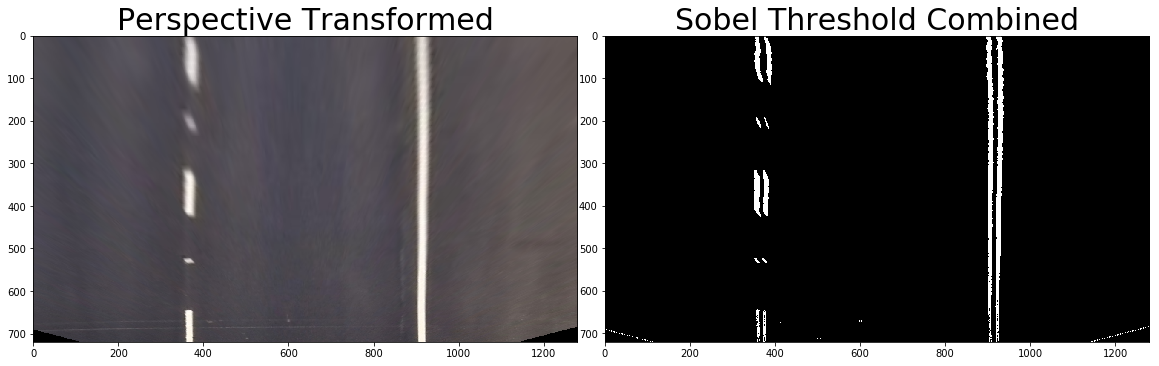

In [15]:
combined_Sobel = np.zeros_like(dir_binary)
# combined[(mag_binary == 1) & (dir_binary == 1)] = 1
combined_Sobel[((x_grad_binary == 1) | (mag_binary == 1) & (dir_binary == 1))] = 1
image_comparison_plot(unwarped_roadImage, 'Perspective Transformed', 
                      combined_Sobel, 'Sobel Threshold Combined',
                      bGrayscale = True)

#### 2.3. Color Space Thresholding

#### <span style="color:darkcyan">Function Definition</span>

In [16]:
def color_thresh(singleChannelImage, thresh):
    binary_output = np.zeros_like(singleChannelImage)
    binary_output[(singleChannelImage > thresh[0]) & (singleChannelImage <= thresh[1])] = 1
    return binary_output

def get_lightness(img):
    L_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 1]
    return L_img
def get_saturation(img):
    S_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
    return S_img

def get_blueYellow(img):
    B_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:, :, 2]
    return B_img

#### <span style="color:darkcyan">These functions are more relavent to the yellow lane, thus we use a different image with yellow lane</span>

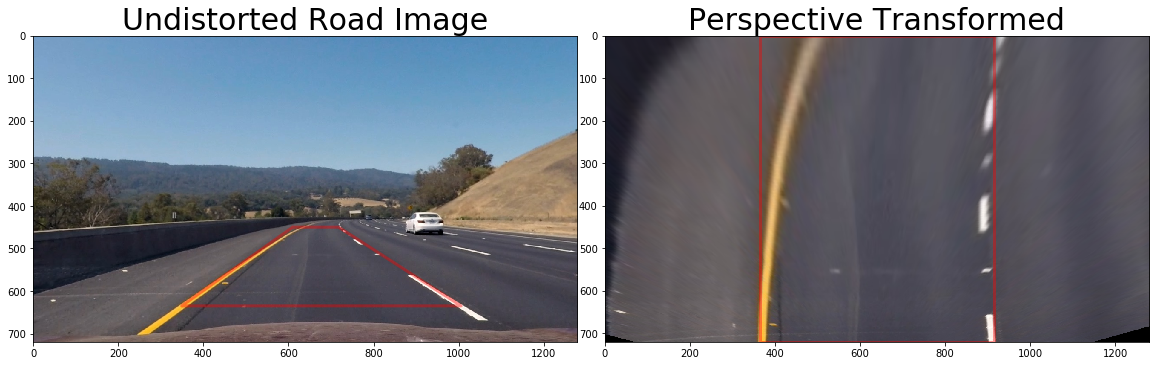

In [17]:
road_yellow_lane = getImg('./test_images/test3.jpg')
undist_yellow_lane = get_undistorted_image(road_yellow_lane, objpoints, imgpoints)

rows2, cols2 = undistorted_roadImg.shape[:2]

left_ref_x2 = (cols2 * 2)//7
right_ref_x2 = (cols2 * 5)//7

src2 = np.float32([(610, 450),
                  (718, 450), 
                  (1006, 635), 
                  (349, 635)])

dst2 = np.float32([(left_ref_x2, 0),
                  (right_ref_x2, 0),
                  (right_ref_x2, rows2),
                  (left_ref_x2, rows2)])

# print(road_yellow_lane)
unwarped_yellowLane, _, _ = img_perspective_transform(undist_yellow_lane, src2, dst2)

# Plot comparison
image_comparison_plot(undist_yellow_lane, 'Undistorted Road Image', 
                      unwarped_yellowLane, 'Perspective Transformed', 
                      oScopeSetting = {'src': src2, 'dst': dst2})

#### 2.3a Lightness Threshold

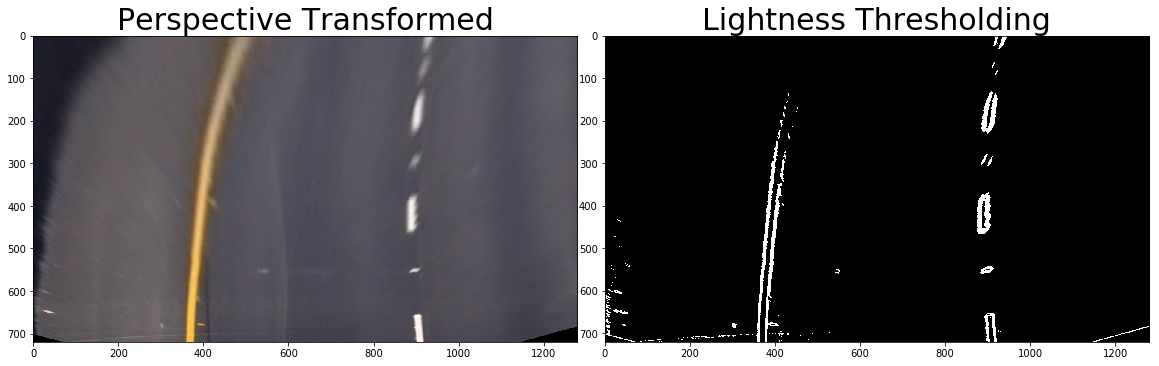

In [18]:
singleChannelImage = get_lightness(unwarped_yellowLane)
# L_binary = color_thresh(singleChannelImage, (112, 200))
L_binary = mag_thresh(singleChannelImage, mag_thresh = (20, 185), bSingleChannel = True)
image_comparison_plot(unwarped_yellowLane, 'Perspective Transformed', 
                      L_binary, 'Lightness Thresholding',
                      bGrayscale = True)

#### 2.3b Saturation Threshold

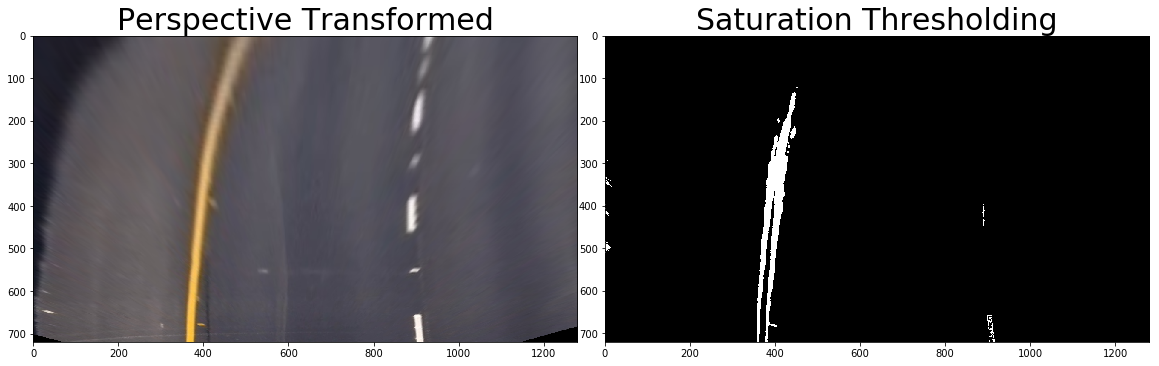

In [19]:
singleChannelImage = get_saturation(unwarped_yellowLane)
S_binary = color_thresh(singleChannelImage, (75, 175))
image_comparison_plot(unwarped_yellowLane, 'Perspective Transformed', 
                      S_binary, 'Saturation Thresholding',
                      bGrayscale = True)

#### 2.3c BlueYellow Threshold

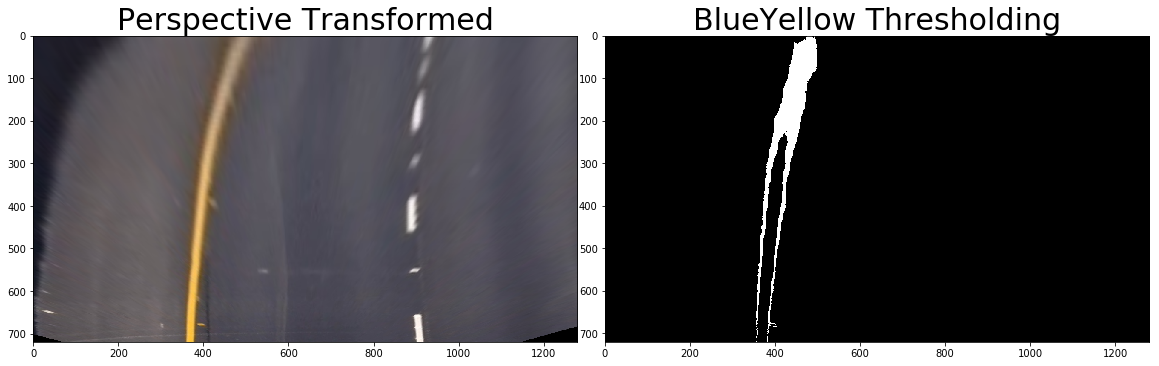

In [20]:
singleChannelImage = get_blueYellow(unwarped_yellowLane)
B_binary = color_thresh(singleChannelImage, (140, 155))
image_comparison_plot(unwarped_yellowLane, 'Perspective Transformed', 
                      B_binary, 'BlueYellow Thresholding',
                      bGrayscale = True)

#### 2.4 Combine Lightness, Saturation and BlueYellow

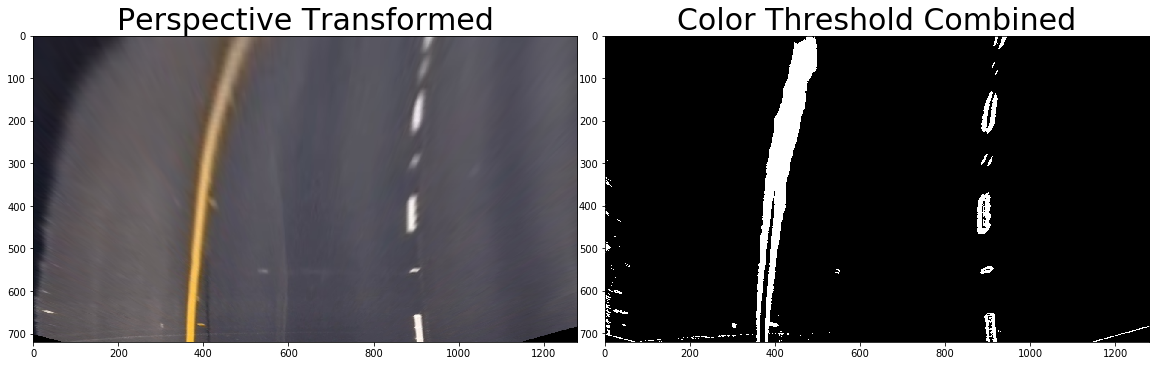

In [21]:
combined_color = np.zeros_like(dir_binary)
combined_color[((B_binary == 1) | (S_binary == 1) | (L_binary == 1))] = 1
image_comparison_plot(unwarped_yellowLane, 'Perspective Transformed', 
                      combined_color, 'Color Threshold Combined',
                      bGrayscale = True)

#### 2.5 Define threshold processing pipeline

In [22]:
# def color_thresh_pipeline(unwarped_img, sx_thresh=(20, 185), S_thresh=(70, 200), B_thresh = (140, 170)):
def color_thresh_pipeline(unwarped_img, sx_thresh=(20, 185), S_thresh=(125, 255), B_thresh = (220, 255)):
    img = np.copy(unwarped_img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    B_channel = get_blueYellow(img)
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = color_thresh(s_channel, S_thresh)
    
#     # additional yellow color channel
#     B_binary = color_thresh(B_channel, B_thresh)
    
    # Stack each channel to view each individual contribution
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combined_corlor_binary = np.zeros_like(sxbinary)
    combined_corlor_binary[(s_binary == 1) | (sxbinary == 1)] = 1
#     combined_corlor_binary[(s_binary == 1) | (B_binary == 1)] = 1
#     combined_corlor_binary[((B_binary == 1) | (s_binary == 1) | (sxbinary == 1))] = 1
    
    return combined_corlor_binary, color_binary

#### 2.6 Test on the color_thresh_pipeline

In [23]:
def color_pipeline_plot(unwarped_img, sTitleUnwarp, 
                        color_tribute, sTitleContribute,
                        corlo_binary, sTitleBinary):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    fig.subplots_adjust(hspace = .2, wspace=.05)
    
    ax1.imshow(unwarped_img)
    ax1.set_title(sTitleUnwarp, fontsize = 20)
    ax2.imshow(color_tribute)
    ax2.set_title(sTitleContribute, fontsize = 20)
    ax3.imshow(corlo_binary, cmap = 'gray')
    ax3.set_title(sTitleBinary, fontsize = 20)
    
    plt.show()

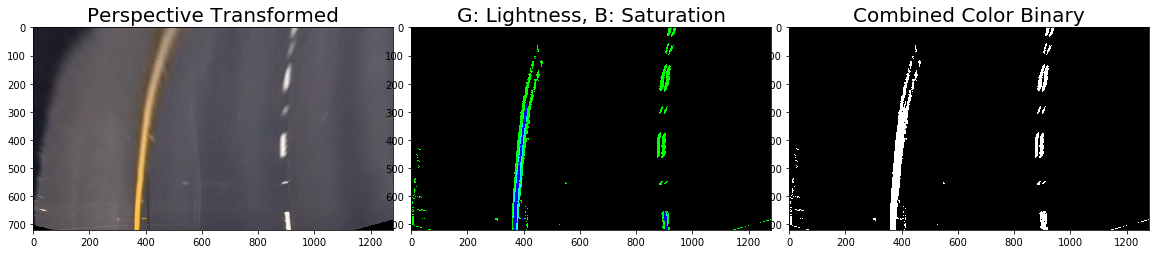

In [24]:
combined_color, color_contribute = color_thresh_pipeline(unwarped_yellowLane)
color_pipeline_plot(unwarped_yellowLane, 'Perspective Transformed', 
                    color_contribute, 'G: Lightness, B: Saturation', 
                    combined_color, 'Combined Color Binary')


### 3. Sliding Window Search

#### 3.1 Find the center of the lane lines by finding the peak value position from the historgram

In [25]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

def plot_binary_hist(unwarped_binary_img, sTitleUnwarpBinary, 
                     mid_point_enabled = False):
    histogram = hist(unwarped_binary_img)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,10))
    fig.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(unwarped_binary_img)
    ax1.set_title(sTitleUnwarpBinary, fontsize = 20)
    
    ax2.plot(histogram)
    if mid_point_enabled:
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        ax2.axvline(x = leftx_base, color = 'r')
        ax2.axvline(x = rightx_base, color = 'r')

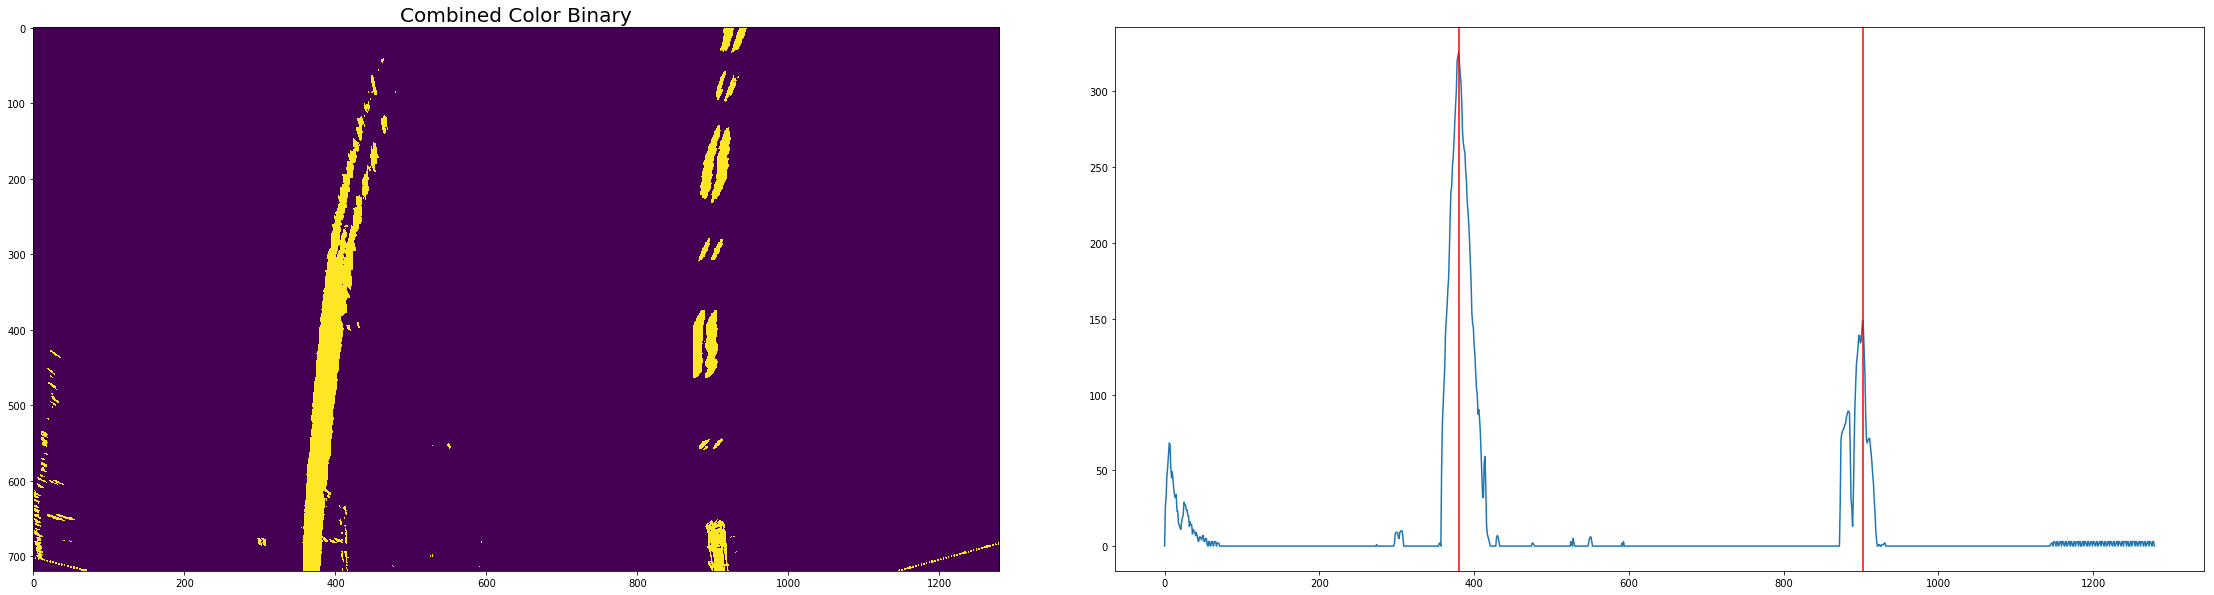

In [26]:
plot_binary_hist(combined_color, "Combined Color Binary", mid_point_enabled = True)

#### 3.2 Sliding window polyfit

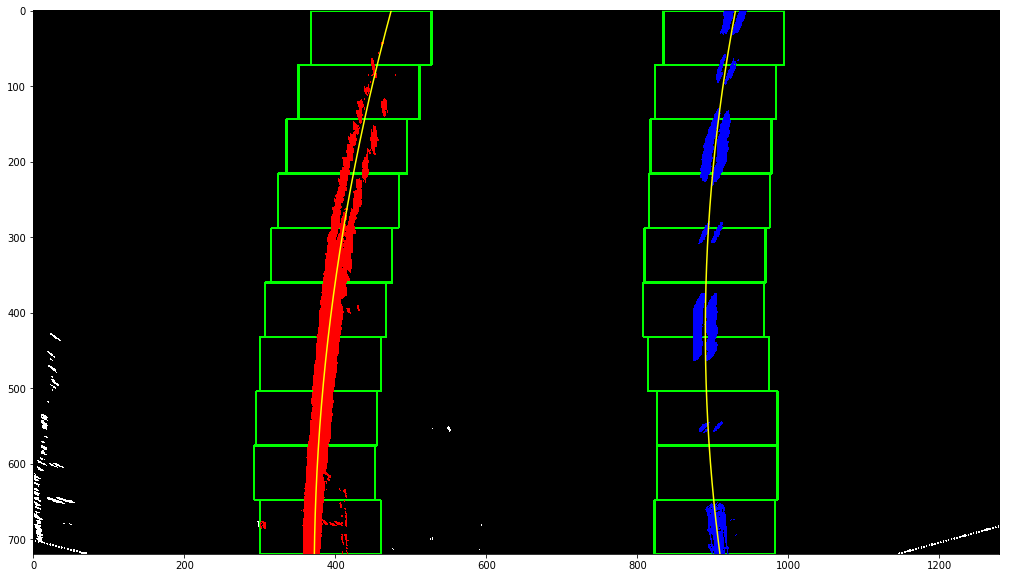

In [27]:
def sliding_window_polyfit(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
#     leftx_base = np.argmax(histogram[:midpoint])
#     rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    quarter_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 10
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def sliding_window_polyfit2(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

def fit_polynomial(unwarped_binary):
    binary_warped = unwarped_binary * 255
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = sliding_window_polyfit(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, (left_fitx, right_fitx), ploty

def plot_ploy_fit(unwarped_binary):
    out_img, x_fits, y_plot = fit_polynomial(unwarped_binary)
    plt.figure(figsize=(40,10))
    plt.plot(x_fits[0], y_plot, color='yellow')
    plt.plot(x_fits[1], y_plot, color='yellow')
    plt.imshow(out_img)
    plt.show()

plot_ploy_fit(combined_color)

#### 3.3 Polyfit Using Fit from Previous Frame

##### <span style="color:darkcyan">Using two similar enough image to mimic previous frames</span>

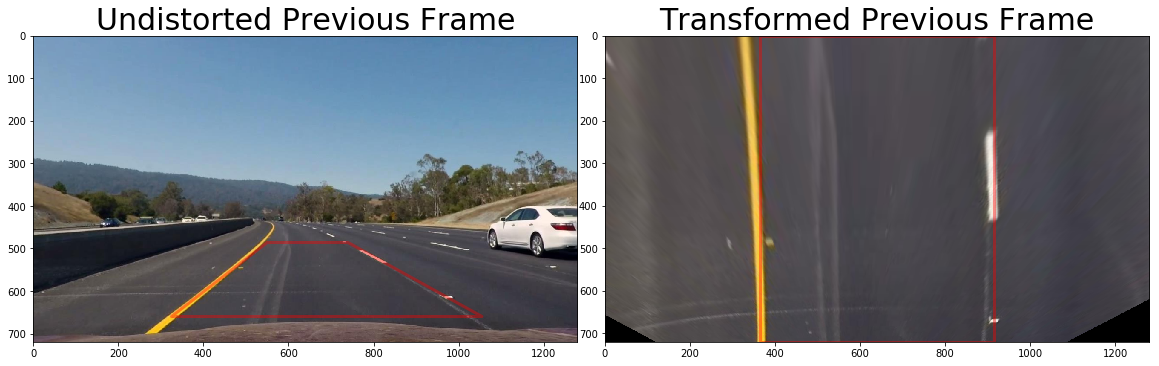

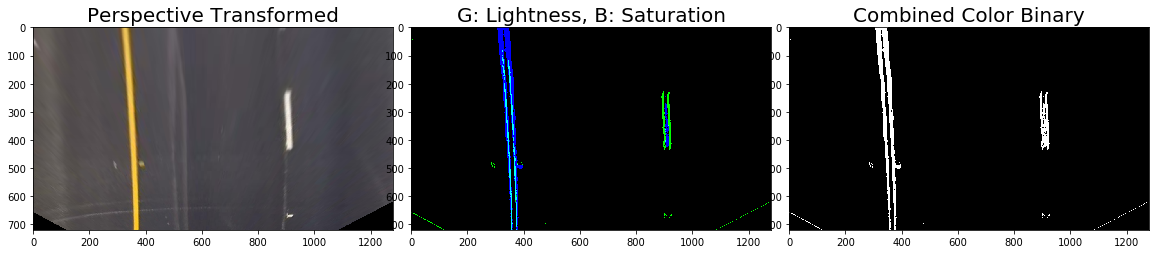

In [28]:
frame_prev = getImg('./test_images/frame2.jpg')
undist_prev = get_undistorted_image(frame_prev, objpoints, imgpoints)

rows3, cols3 = undist_prev.shape[:2]

left_ref_x3 = (cols3 * 2)//7
right_ref_x3 = (cols3 * 5)//7

src3 = np.float32([(550, 486),
                  (740, 486), 
                  (1055, 660), 
                  (325, 660)])

dst3 = np.float32([(left_ref_x3, 0),
                  (right_ref_x3, 0),
                  (right_ref_x3, rows3),
                  (left_ref_x3, rows3)])

unwarped_prev, _, _ = img_perspective_transform(undist_prev, src3, dst3)

# Plot comparison
image_comparison_plot(undist_prev, 'Undistorted Previous Frame', 
                      unwarped_prev, 'Transformed Previous Frame', 
                      oScopeSetting = {'src': src3, 'dst': dst3})

combined_color_prev, color_contribute_prev = color_thresh_pipeline(unwarped_prev, 
                                                                   sx_thresh=(45, 134), 
                                                                   S_thresh=(70, 200), 
                                                                   B_thresh = (140, 170))
color_pipeline_plot(unwarped_prev, 'Perspective Transformed', 
                    color_contribute_prev, 'G: Lightness, B: Saturation', 
                    combined_color_prev, 'Combined Color Binary')

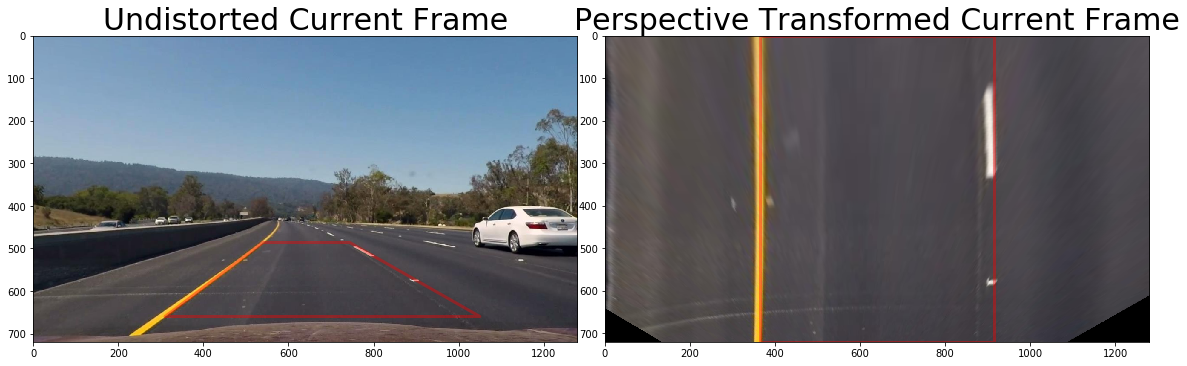

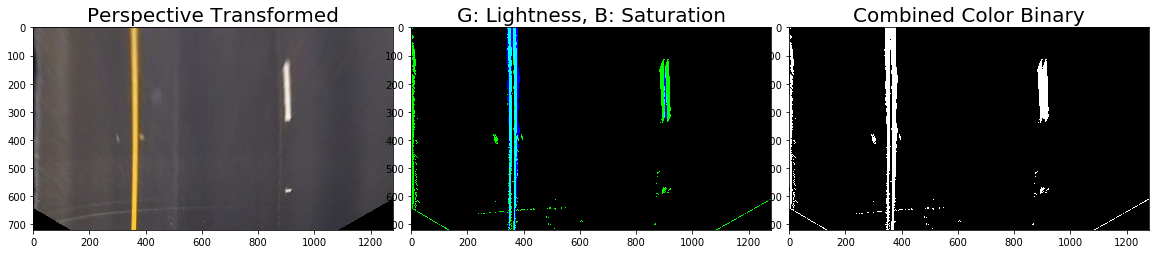

In [29]:
frame_current = getImg('./test_images/frame4.jpg')
undist_current = get_undistorted_image(frame_current, objpoints, imgpoints)

rows4, cols4 = undist_current.shape[:2]

left_ref_x4 = (cols4 * 2)//7
right_ref_x4 = (cols4 * 5)//7

src4 = np.float32([(540, 486),
                  (744, 486), 
                  (1050, 660), 
                  (310, 660)])

dst4 = np.float32([(left_ref_x4, 0),
                  (right_ref_x4, 0),
                  (right_ref_x4, rows4),
                  (left_ref_x4, rows4)])

unwarped_current, _, _ = img_perspective_transform(undist_current, src4, dst4)

# Plot comparison
image_comparison_plot(undist_current, 'Undistorted Current Frame', 
                      unwarped_current, 'Perspective Transformed Current Frame', 
                      oScopeSetting = {'src': src4, 'dst': dst4})

combined_color_current, color_contribute_current = color_thresh_pipeline(unwarped_current, 
                                                                   sx_thresh=(20, 185), 
                                                                   S_thresh=(70, 200), 
                                                                   B_thresh = (140, 170))
color_pipeline_plot(unwarped_current, 'Perspective Transformed', 
                    color_contribute_current, 'G: Lightness, B: Saturation', 
                    combined_color_current, 'Combined Color Binary')

In [30]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

def search_around_poly(unwarped_binary, left_fit, right_fit ):
    binary_warped = unwarped_binary * 255
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values ###
    # within the +/- margin of our polynomial function ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     ## End visualization steps ##
    
    return result, (left_fitx, right_fitx), ploty

def plot_ploy_fit_prev(prev_img, current_img ):
#     _, x_fits_prev, _ = fit_polynomial(prev_img)
    
    left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
    right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])
    x_fits_prev = [left_fit, right_fit]
    
    out_img, x_fits_curr, y_plot = search_around_poly(current_img, x_fits_prev[0], x_fits_prev[1])
    plt.figure(figsize=(40,10))
    plt.plot(x_fits_curr[0], y_plot, color='yellow')
    plt.plot(x_fits_curr[1], y_plot, color='yellow')
    plt.imshow(out_img)
    plt.show()

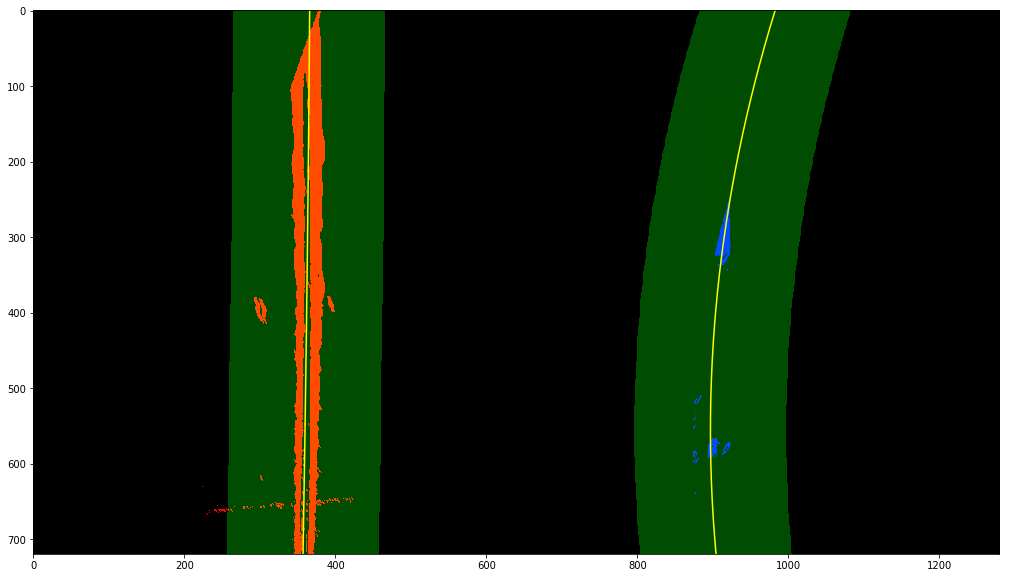

In [31]:
plot_ploy_fit_prev(combined_color_prev, combined_color_current)

#### 3.4 Radius of Curvature and Distance from Lane Center Calculation

In [32]:
def generate_data(combined_color_binary, 
                  ym_per_pix, xm_per_pix, 
                  l_lane_indices, r_lane_indices):
    
    global temp_left_cr
    global temp_right_cr
    
    rows, _ = combined_color_binary.shape
    
    ploty = np.linspace(0, rows - 1, num= rows)# to cover same y-range as image
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_color_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[l_lane_indices]
    lefty = nonzeroy[l_lane_indices] 
    rightx = nonzerox[r_lane_indices]
    righty = nonzeroy[r_lane_indices]

    if len(leftx) != 0 and len(rightx) != 0:
        # Fit a second order polynomial to pixel positions in each fake lane line
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        temp_left_cr = left_fit_cr
        temp_right_cr = right_fit_cr
    else:
        left_fit_cr = temp_left_cr
        right_fit_cr = temp_right_cr
    
    return ploty, left_fit_cr, right_fit_cr

def measure_curvature_real(combined_color_binary, 
                          leftFit, rightFit, 
                          left_lane_indices, right_lane_indices,
                          ym_per_img = 13, xm_per_img = 3.7):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    left_curverad = 0
    right_curverad = 0 
    center_dist = 0
    
    rows, cols  = combined_color_binary.shape
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = ym_per_img / rows # meters per pixel in y dimension
    xm_per_pix = xm_per_img / 548 # meters per pixel in x dimension
    
    ploty, left_fit_cr, right_fit_cr = generate_data(combined_color_binary, 
                                                  ym_per_pix, xm_per_pix, 
                                                  left_lane_indices, right_lane_indices)
    
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculate the R_curve
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Distance from center is image x midpoint - mean of left_fit_x_int and right_fit_x_int intercepts 
    if leftFit is not None and rightFit is not None:
        car_position = combined_color_binary.shape[1]/2
        left_fit_x_int = leftFit[0] * rows**2 + leftFit[1] * rows + leftFit[2]
        right_fit_x_int = rightFit[0] * rows**2 + rightFit[1] * rows + rightFit[2]
        lane_center_position = (left_fit_x_int + right_fit_x_int) /2
        center_offset = (car_position - lane_center_position) * xm_per_pix
        
    return left_curverad, right_curverad, center_offset


##### <span style="color:darkcyan">Calculate lane curvature and center offset</span>

In [33]:
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit2(combined_color)

left_curverad, right_curverad, center_offset = measure_curvature_real(combined_color, 
                                               left_fit, right_fit, 
                                               left_lane_inds, right_lane_inds, 
                                               ym_per_img = 13, xm_per_img = 3.7)


print('Radius of curvature for example:', left_curverad, 'm,', right_curverad, 'm')
print('Distance from lane center:', center_offset, 'm')

Radius of curvature for example: 134.6583539633959 m, 109.23269324132642 m
Distance from lane center: -0.004539624130614956 m


In [34]:
# color_pipeline_plot(unwarped_yellowLane, 'Perspective Transformed', 
#                     color_contribute, 'G: Lightness, B: Saturation', 
#                     combined_color, 'Combined Color Binary')

#### 3.5 Draw the detected lane overlay

In [35]:
def draw_lane(original_img, combined_binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(combined_binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    rows, cols = combined_binary_img.shape
    ploty = np.linspace(0, rows-1, num=rows)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (cols, rows)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

##### <span style="color:darkcyan">A reminder of what the test image is just in case if you forgot</span>

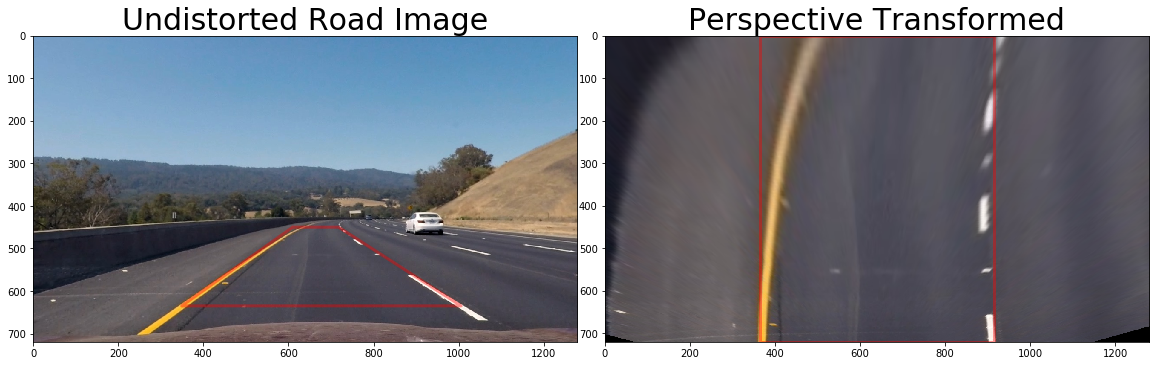

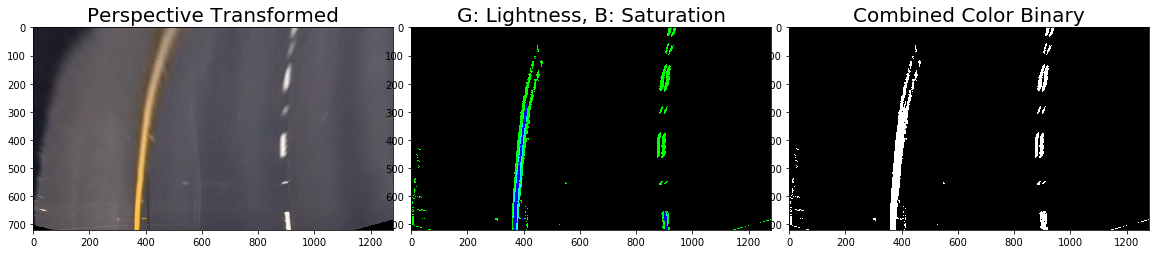

In [36]:
road_yellow_lane = getImg('./test_images/test3.jpg')
undist_yellow_lane = get_undistorted_image(road_yellow_lane, objpoints, imgpoints)
unwarped_yellowLane, M, inverseM = img_perspective_transform(undist_yellow_lane, src2, dst2)

image_comparison_plot(undist_yellow_lane, 'Undistorted Road Image', 
                      unwarped_yellowLane, 'Perspective Transformed', 
                      oScopeSetting = {'src': src2, 'dst': dst2})

combined_color, color_contribute = color_thresh_pipeline(unwarped_yellowLane)
color_pipeline_plot(unwarped_yellowLane, 'Perspective Transformed', 
                    color_contribute, 'G: Lightness, B: Saturation', 
                    combined_color, 'Combined Color Binary')

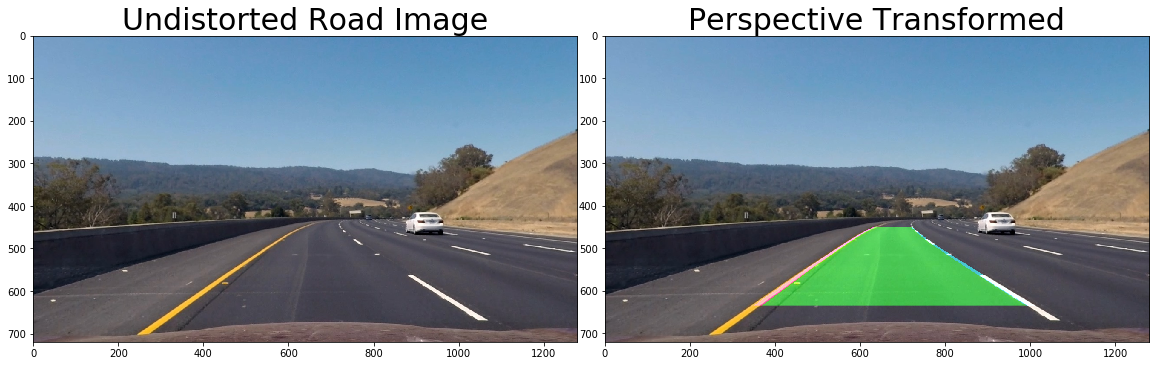

In [37]:
left_fit, right_fit, _, _, _ = sliding_window_polyfit2(combined_color)
lane_overlay = draw_lane(undist_yellow_lane, combined_color, left_fit, right_fit, inverseM)

image_comparison_plot(undist_yellow_lane, 'Undistorted Road Image', 
                      lane_overlay, 'Perspective Transformed')

#### 3.6 Add Curvature and center offset overlay

In [38]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

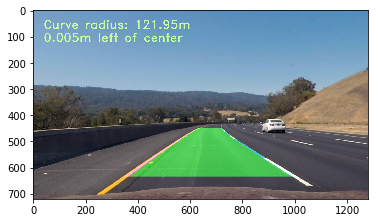

In [39]:
dataLane_overlay = draw_data(lane_overlay, (left_curverad + right_curverad)/2, center_offset)
type(dataLane_overlay)
plt.imshow(dataLane_overlay)

### 4. Pipeline for video processing

In [40]:
src = np.float32([(568,464),
                  (717,464), 
                  (258,682), 
                  (1089,682)])

dst = np.float32([(450,0),
                  (750,0),
                  (450, 720),
                  (750, 720)])

##### <span style="color:darkcyan">Create a line class to store the lane line data</span>

In [41]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.bDetected = False  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.bDetected = False
            else:
                self.bDetected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.bDetected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)

##### <span style="color:darkcyan">Define image processor</span>

In [42]:
def image_processor(img):
    new_img = np.copy(img)
    img_binary, Minv = color_pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not left_line.bDetected or not right_line.bDetected:
        left_fit, right_fit, left_lane_indices, right_lane_indices, _ = sliding_window_polyfit2(img_binary)
    else:
        left_fit, right_fit, left_lane_indices, right_lane_indices = polyfit_using_prev_fit(img_binary, left_line.best_fit, right_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        r_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            left_fit = None
            right_fit = None
            
    left_line.add_fit(left_fit, left_lane_indices)
    right_line.add_fit(right_fit, right_lane_indices)
    
    # draw the current best fit if it exists
    if left_line.best_fit is not None and right_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_binary, left_line.best_fit, right_line.best_fit, Minv)
        rad_l, rad_r, d_center = measure_curvature_real(img_binary, left_line.best_fit, right_line.best_fit, 
                                                               left_lane_indices, right_lane_indices)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    return img_out

In [44]:
left_line = Line()
right_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output2.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(image_processor)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████████████████████████████████▉| 1260/1261 [04:44<00:00,  4.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

Wall time: 4min 45s


In [44]:
src = np.float32([(600,480),
                  (730,480), 
                  (350,660), 
                  (950,650)])

dst = np.float32([(450,0),
                  (750,0),
                  (450, 720),
                  (750, 720)])

left_line = Line()
right_line = Line()

In [51]:
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(10,12)
processed_video2 = video_input2.fl_image(image_processor)
%time processed_video2.write_videofile(video_output2, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4



 42%|████████████████▋                       | 202/485 [00:15<00:21, 13.02it/s]


 84%|█████████████████████████████████▍      | 406/485 [00:30<00:05, 13.39it/s]


100%|████████████████████████████████████████| 485/485 [00:37<00:00, 13.09it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 37.9 s


#### Need to come up with better scoping technique for this

In [44]:
left_line = Line()
right_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video3 = video_input3.fl_image(image_processor)
%time processed_video3.write_videofile(video_output3, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


100%|█████████████████████████████████████▉| 1199/1200 [01:56<00:00, 10.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 1min 58s
